In [1]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb
import ast

In [2]:
droughts_df = pd.read_csv('../rival_framings_demand/drought_counts_all_realizations.csv', index_col=0)

In [3]:
# directory where the experiment data is stored
flow_data_dir = '../rival_framings_demand/xdd_parquet_flow'

Identify realizations similar or better than history (drought years=22)

In [47]:
realizations_history=tuple(map(str, np.where((droughts_df['Total counts'] >=10) & (droughts_df['Total counts'] <= 22))[0]))

Function converting order number to sample and realization for file retrieval

In [6]:
no_to_realization = lambda x: (int(x/10)+1, (x)%10+1)

Identify all samples that produce these realizations

In [7]:
samples = tuple(np.unique([no_to_realization(x)[0] for x in realizations_history]))

Create glob path to specific realization results

In [54]:
# target glob path
glob_path = os.path.join(flow_data_dir, f'S*_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

In [55]:
#limits rows to those that belong to list of realizations
sql = f"""
SELECT 
    *
FROM
    '{glob_path}'
WHERE
    (sample-1)*10+realization in {realizations_history}; 
"""

df = duckdb.query(sql).df()
df

,structure_id,year,month,demand,shortage,river_outflow,control_location,sample,realization
0,09010500,1908,OCT,0,0,2076,NaN,1,6
1,09010500,1908,NOV,0,0,1449,NaN,1,6
2,09010500,1908,DEC,0,0,844,NaN,1,6
3,09010500,1909,JAN,0,0,600,NaN,1,6
4,09010500,1909,FEB,0,0,522,NaN,1,6
...,...,...,...,...,...,...,...,...,...
45366295,09163500,2013,MAY,0,0,132537,NaN,17,3
45366296,09163500,2013,JUN,0,0,129776,NaN,17,3
45366297,09163500,2013,JUL,0,0,84393,NaN,17,3
45366298,09163500,2013,AUG,0,0,86346,NaN,17,3


In [60]:
df['realization_number']=(df['sample']-1)*10+df['realization']

In [125]:
shortage_ratio = []
years_list = []
for i in realizations_history:
    years = ast.literal_eval(droughts_df.at[int(i),'Drought years'])[1]
    years = [x+1908 for x in years]
    total_demand = df.loc[(df['realization_number'] == int(i)) & (df['year'].isin(years)), 'demand'].sum()
    total_shortage = df.loc[(df['realization_number'] == int(i)) & (df['year'].isin(years)), 'shortage'].sum()
    shortage_ratio.append(total_shortage/total_demand)
    years_list.append(len(years))

/home/fs02/pmr82_0001/ah986/rival_framings/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


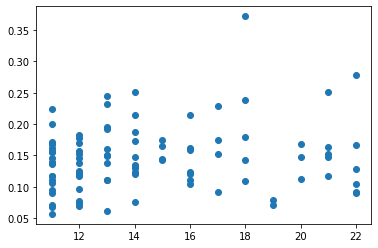

In [126]:
import matplotlib.pyplot as plt
plt.scatter(years_list, shortage_ratio)
plt.show()